In [9]:
import importlib
import pipeline as pp
import stats_hc as hc
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import numpy as np

In [10]:
tab20 = plt.get_cmap('tab20').colors
hex_colors = ['#' + ''.join(f'{int(c*255):02x}' for c in color) for color in tab20]
print(hex_colors)

['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']


In [11]:
# Define the types
types = [
    'fake',
    'conspiracy',
    'junksci',
    'hate',
    'unreliable',
    'bias',
    'satire',
    'reliable',
    'clickbait',
    'political',
]
# Assign colors to each type from the Tab20 color map
colors = plt.get_cmap('tab10').colors[:len(types)]
# Add black color for unknown types
unknown_types = set(types)  # get all other unknown types
colors += tuple(['black'] * len(unknown_types))  # add black color for other unknown types
# Create a dictionary mapping each type to its assigned color
types_colors = {types[i]: colors[i] for i in range(len(types))}

types_liar = [
    'pants-fire',
    'false',
    'mostly-false',
    'barely-true',
    'half-true',
    'mostly-true',
    'true',
]
# Assign colors to each type from the Tab20 color map
colors = plt.get_cmap('tab10').colors[:len(types_liar)]
# Add black color for unknown types
unknown_types = set(types_liar)  # get all other unknown types
colors += tuple(['black'] * len(unknown_types))  # add black color for other unknown types
# Create a dictionary mapping each type to its assigned color
types_liar_colors = {types_liar[i]: colors[i] for i in range(len(types_liar))}

In [12]:
importlib.reload(hc)
liar_set = True
if liar_set:
    data = pd.read_csv("../datasets/liar_dataset/cleaned/combined_cleaned.csv")
    Stat = hc.Statistics(data=data, content_label="statement_cleaned", type_label="label", binary_type_label='label_binary', type_colors=types_liar_colors, sentence_analysis_label="sentence_analysis", party_label="party", speaker_label="speaker", subjects_label="subjects")
else:
    data = pd.read_csv("../datasets/sample/dataset_combined.csv")
    Stat = hc.Statistics(data=data, content_label="content_cleaned", type_label="type", binary_type_label='type_binary', domain_label='domain', type_colors=types_colors, sentence_analysis_label="sentence_analysis")

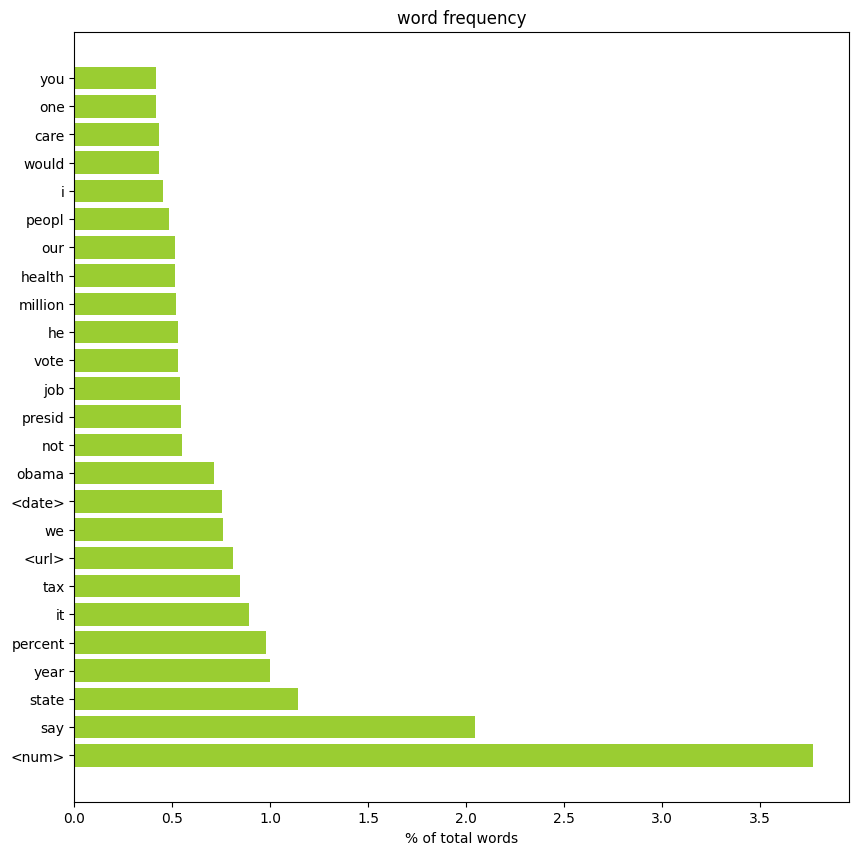

In [13]:
Stat.barplot_word_frequency()

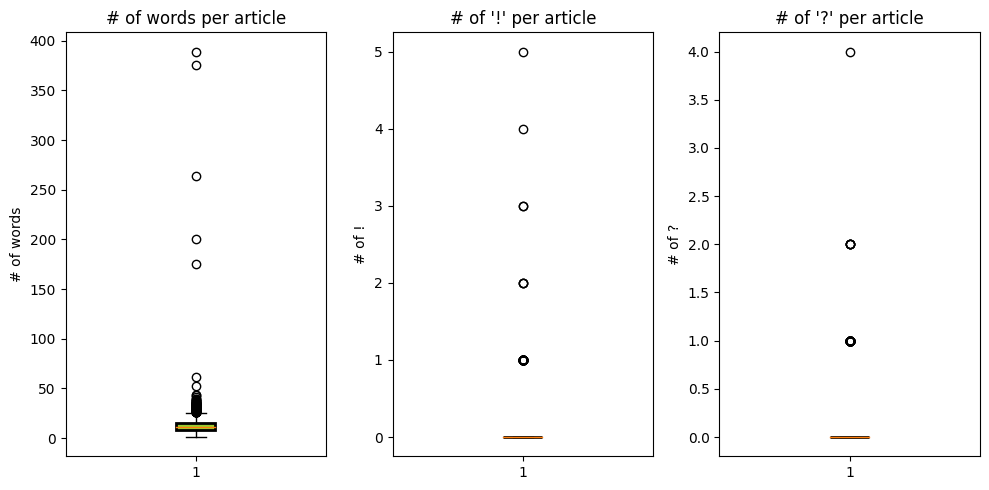

In [14]:
Stat.boxplot_word_frequency()

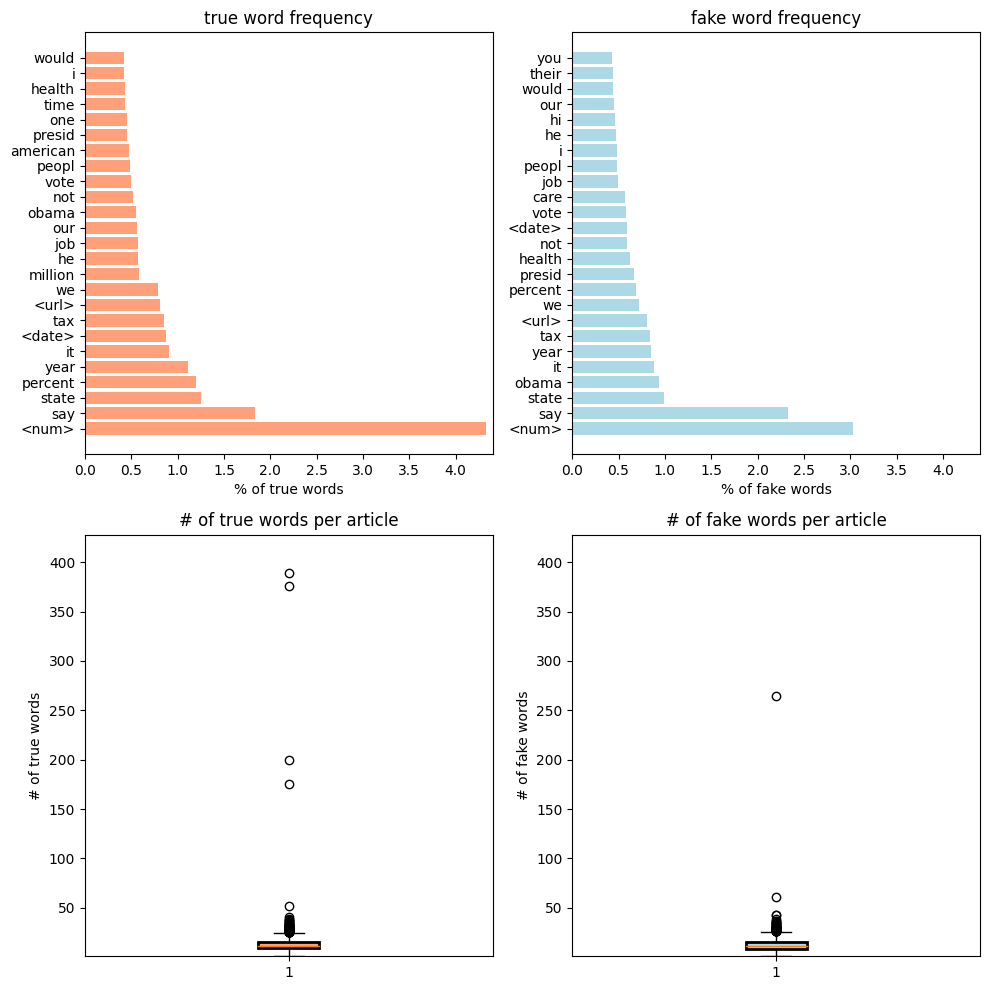

In [15]:
Stat.plot_word_frequency_fake_vs_true()

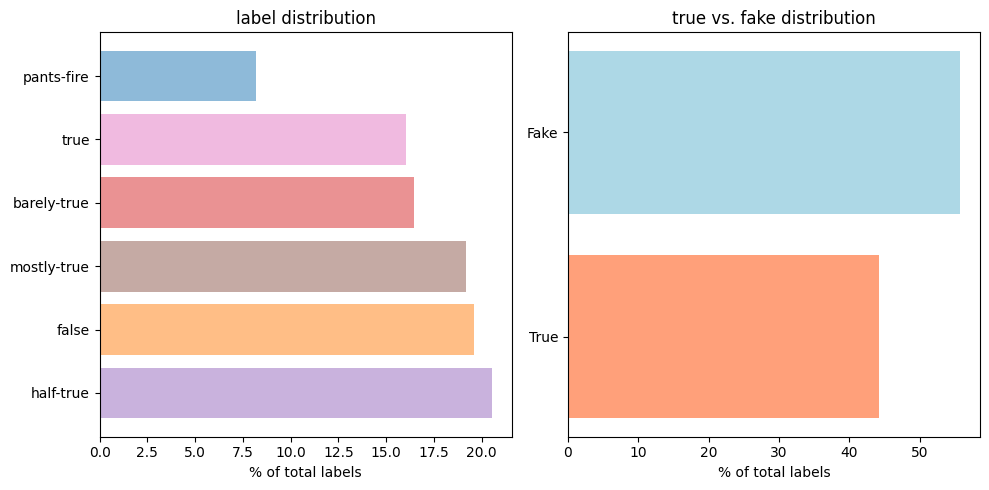

In [16]:
Stat.plot_type_fake_vs_true()

In [17]:
if not liar_set:
    Stat.barplot_domain()

In [18]:
threshold=0
percentage=True
if not liar_set:
    Stat.barplot_x_to_y_contribution(threshold=threshold, percentage=percentage, x_label='domain', y_label='type', content_label='content_cleaned', title=f'domain contribution to label ( ≥ {threshold}%)' if percentage else f'domain contribution to label ( {threshold} most frequent)')

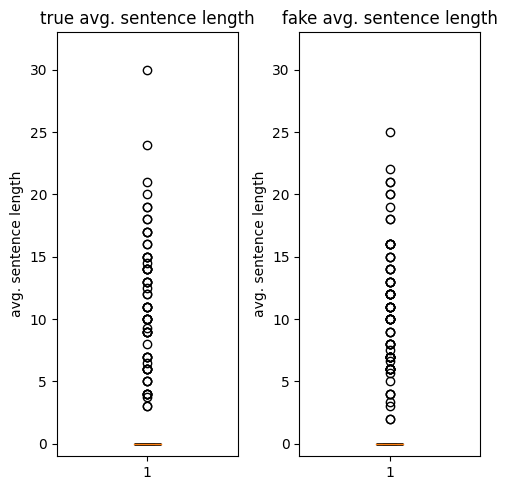

In [19]:
Stat.plot_average_sentence_length_fake_vs_true()

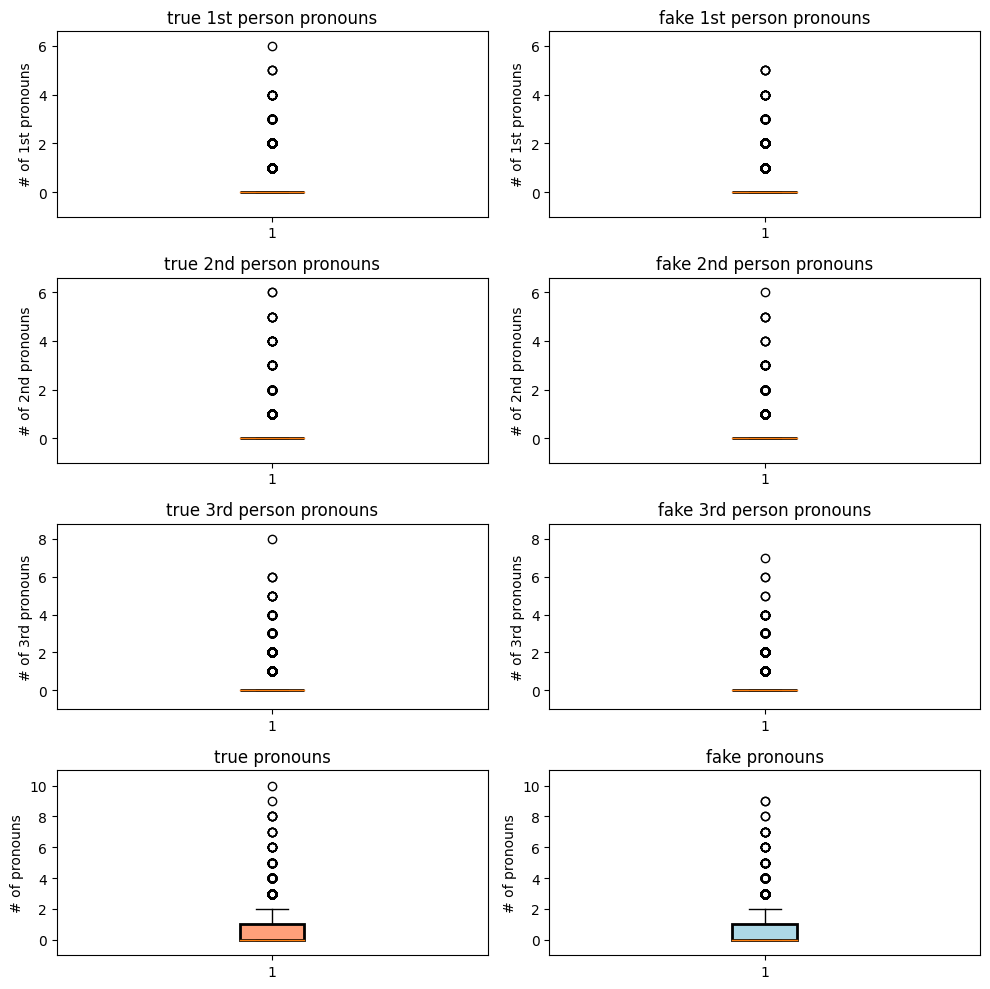

In [20]:
Stat.plot_pronouns_fake_vs_true()

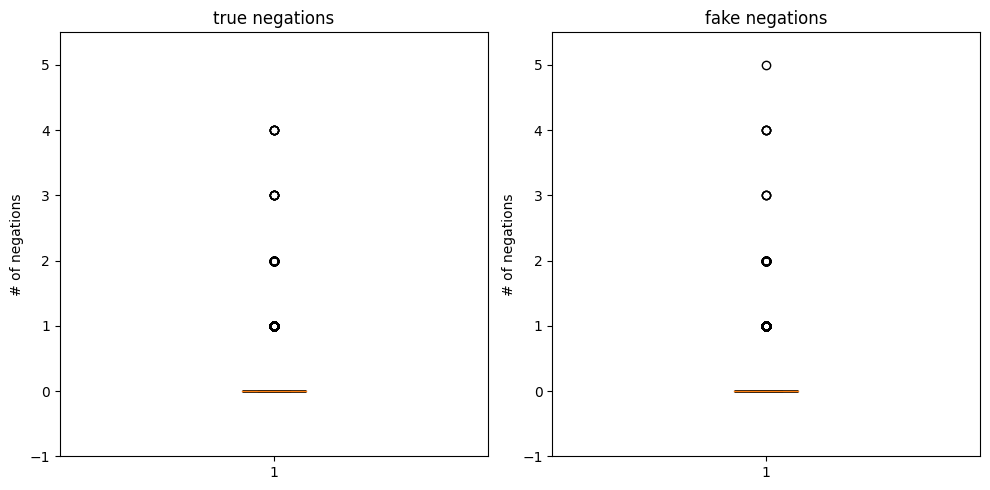

In [21]:
Stat.plot_negations_fake_vs_true()

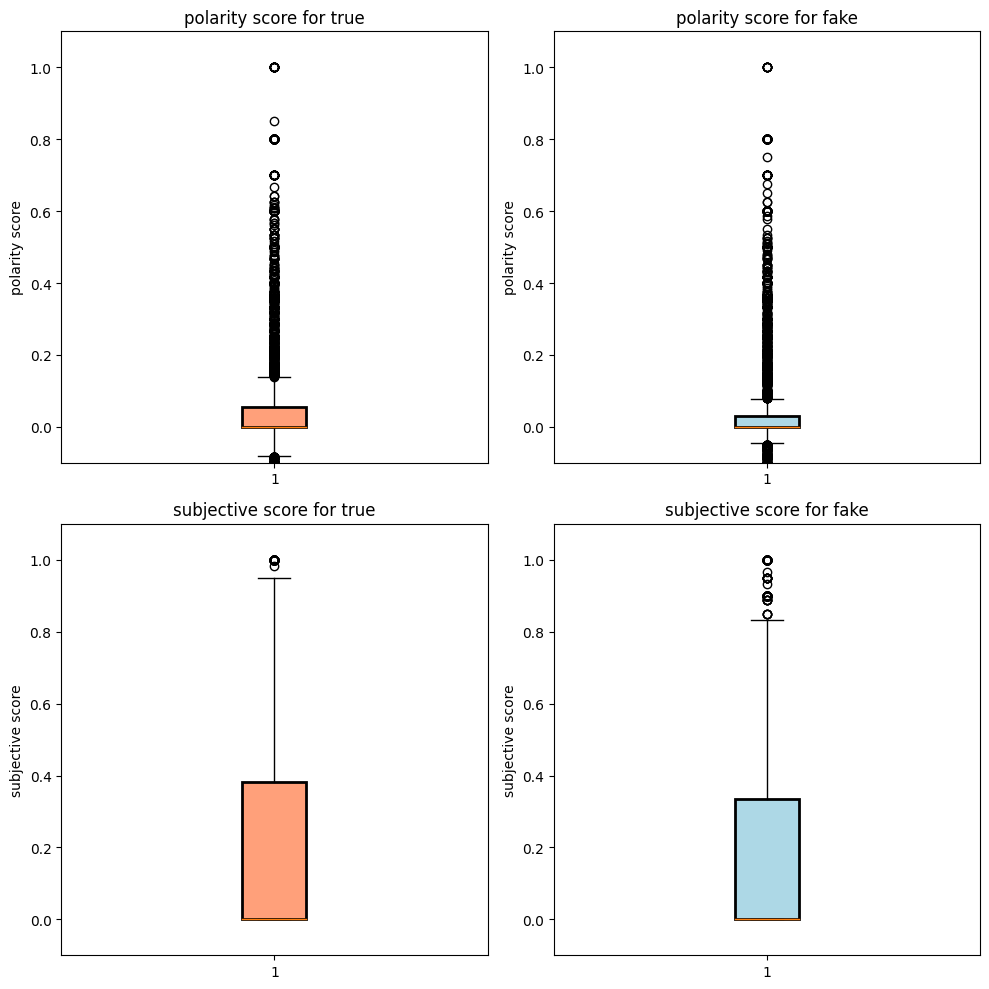

In [22]:
Stat.plot_sentence_analysis_fake_vs_true()

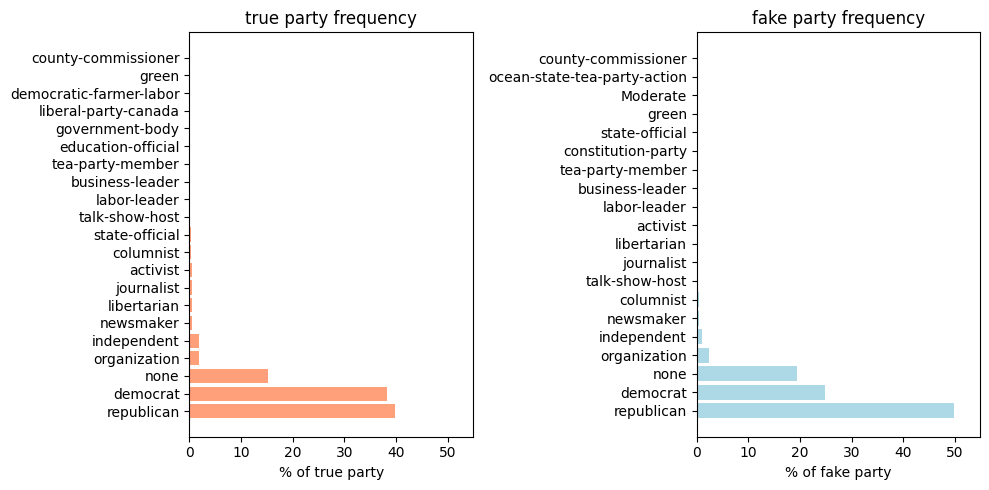

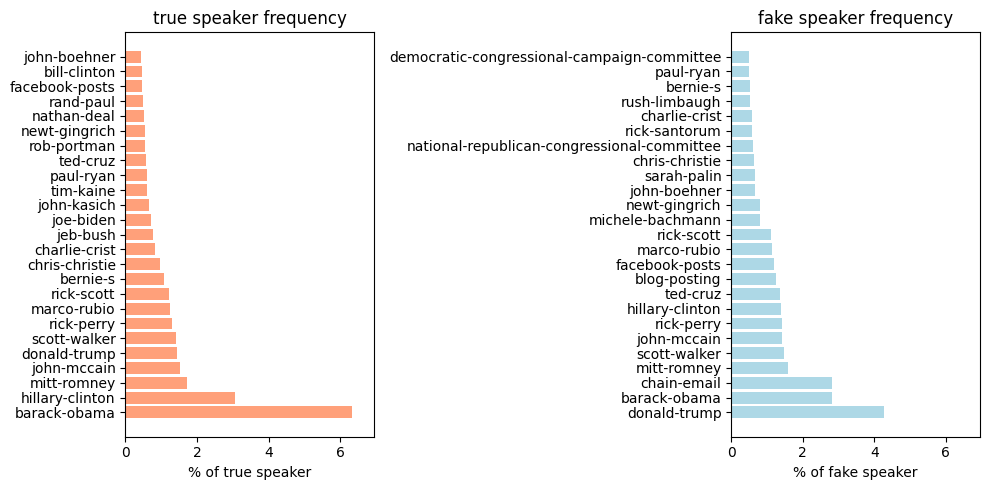

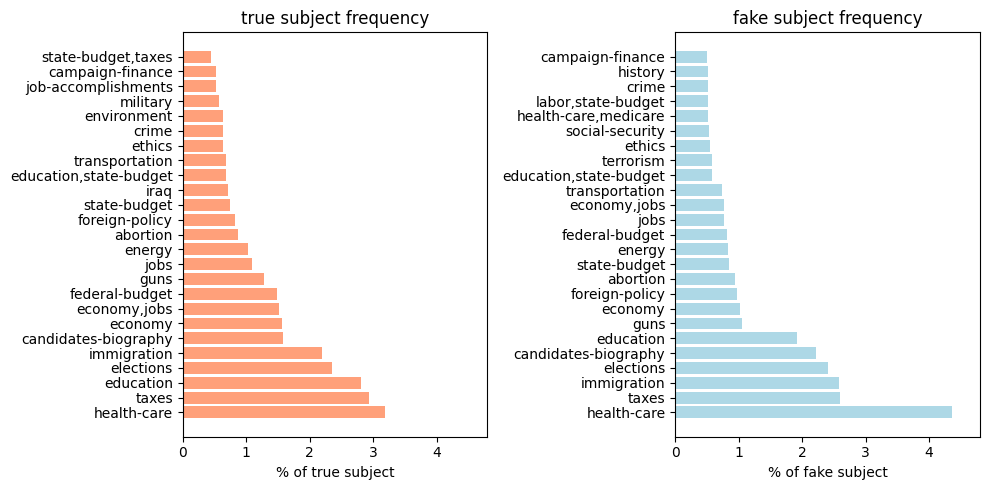

In [23]:
if liar_set:
    Stat.plot_party_fake_vs_true()
    Stat.plot_speaker_fake_vs_true()
    Stat.plot_subjects_fake_vs_true()

## KMeans Clustering

The KMeans clustering algorithm uses the TF-IDF (Term Frequency-Inverse Document Frequency) matrix as input to cluster the documents into k clusters. The TF-IDF matrix represents each document as a vector of term frequencies, normalized by their inverse document frequency across the corpus.

The KMeans algorithm then iteratively assigns each document to a cluster and updates the cluster centroids until convergence. The assignment is based on the similarity between the document vector and the centroid of each cluster. The similarity metric used is the Euclidean distance between the document vector and the centroid vector in the TF-IDF space.

In addition to the TF-IDF matrix, the KMeans algorithm takes several parameters, including the number of clusters (k), the initialization method (e.g., k-means++), the maximum number of iterations, and the number of times the algorithm will be run with different random initializations.

In [24]:
data = pd.read_csv('../datasets/big/dataset_bin.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../datasets/big/dataset_bin.csv'

In [ ]:
data = pd.read_csv("../datasets/big/dataset_unbalanced_cleaned.csv")

In [ ]:
# Vectorize the corpus using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data['content_tokenized'].values.astype('U'))

### Plot the elbow curve to determine the optimal number of clusters.

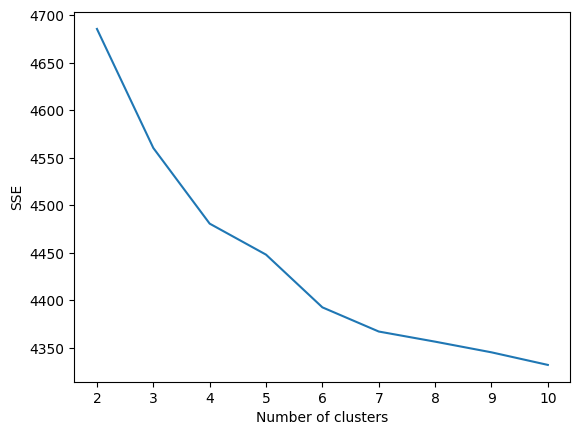

In [ ]:
# Calculate SSE for different values of k
sse = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=10).fit(tfidf)
    sse[k] = kmeans.inertia_ 

# Plot SSE against k
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

### Perform clustering using the result from the elbow curve.

In [ ]:
# Perform K-Means clustering


num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=10)
kmeans.fit(tfidf)



# Print the top terms in each cluster
# print("Top terms per cluster:")
# order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
# terms = tfidf_vectorizer.get_feature_names_out()
# for i in range(num_clusters):
#     # print(f"Cluster {i} terms: ", end='')
#     for j in order_centroids[i, :10]:
#         print(f"{terms[j]}, ", end='')
#     # print()

# # Visualize the clusters
# plt.scatter(tfidf[:, 0], tfidf[:, 1], c=kmeans.labels_, cmap='rainbow')
# plt.show()

KMeans(max_iter=100, n_clusters=6, n_init=10)

In [ ]:
# Calculate silhouette score
silhouette_avg = silhouette_score(tfidf.toarray(), kmeans.labels_, metric='euclidean', n_jobs=-1)

# Print silhouette score
print("The average silhouette_score is :", silhouette_avg)

KeyboardInterrupt: 

: 

### Plot the clusters using a a scatterplot in 2d with PCA.

/var/folders/85/ql5yb2_14pzc9s20ccfhqs7m0000gn/T/ipykernel_23717/3378127257.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tfidf_2d[:, 0], tfidf_2d[:, 1],


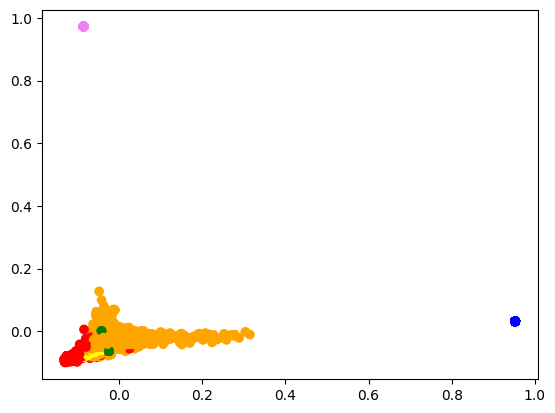

In [ ]:
# Reduce the dimensions of the data using PCA
pca = PCA(n_components=2)
tfidf_2d = pca.fit_transform(tfidf.toarray())

label_to_color = {0: 'red', 1: 'blue', 2: 'green', 3: 'violet', 4: "yellow", 5: "orange"}
colors = [label_to_color[label] for label in kmeans.labels_]

# Visualize the clusters
plt.scatter(tfidf_2d[:, 0], tfidf_2d[:, 1], 
            c=colors, 
            cmap='rainbow',
            )
plt.show()

In [ ]:
kmeans.labels_

array([2, 2, 2, ..., 2, 2, 2], dtype=int32)

In [ ]:
label_to_color = {0: 'red', 1: 'blue', 2: 'green', 3: 'violet', 4: "yellow", 5: "orange"}

In [ ]:
# Print the top terms in each cluster
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1] # sort the centroids by their distance to the origin
terms = tfidf_vectorizer.get_feature_names_out()
for i in range(num_clusters):
    print(f"Cluster {label_to_color[i]} terms: ", end='')
    for j in order_centroids[i, :10]:
        print(f"{terms[j]}, ", end='')
    print()

Top terms per cluster:
Cluster red terms: num, said, mr, date, trump, state, url, new, peopl, obama, 
Cluster blue terms: tor, tail, anonymis, usb, browser, dvd, submiss, stick, comput, internet, 
Cluster green terms: num, url, date, use, like, said, time, new, news, year, 
Cluster violet terms: updat, bookmark, sputnik, dear, excit, radio, voic, websit, russia, stay, 
Cluster yellow terms: iran, iranian, nuclear, suprem, islam, minist, leader, tehran, ali, republ, 
Cluster orange terms: num, rec, date, url, properti, trump, valu, republican, post, moor, 


In [ ]:
# add the list with the cluster labels to the dataframe
# modify the cluster label to be a string with the color of the cluster plus the word cluster in front
data['cluster'] = kmeans.labels_
# add the cluster label to the content

# concat the cluster label to the content

# create a new column 'cluster_color' that maps cluster labels to color codes
data['cluster_color'] = data['cluster'].map(label_to_color)

# create a new column 'cluster_string' that concatenates the color code and cluster label string
data['cluster_string'] = data['cluster_color'] + 'Cluster'

data['content_with_cluster'] = data['content'] + ' ' + data['cluster_string'].astype(str)

# add the top terms per cluster to the dataframe
# data['top_terms'] = data['cluster'].map(lambda x: [terms[j] for j in order_centroids[x, :10]])

# write panda frame data to ../datasets/big/dataset_bin.csv"
# data.to_csv('../datasets/big/dataset_unbalanced_cleaned_cluster.csv', index=False)


data['content'] = data['content'].apply(lambda x: x + " " + str(kmeans.labels_))

,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,...,content_combined,content_authors,content_title,content_domain,content_domain_authors_title,cluster,cluster_color,cluster_string,content_with_cluster,top_terms
0,6301449,nytimes,reliable,https://query.nytimes.com/gst/fullpage.html?re...,\n\nTo the Editor:\n\nRe ''Drop Out of the Col...,2018-02-11 00:40:10.316783,2018-02-11 00:14:20.346838,2018-02-11 00:14:20.346871,time scrap elector colleg ?,,...,editor drop colleg editori march <num> written...,editor drop colleg editori march <num> written...,editor drop colleg editori march <num> written...,editor drop colleg editori march <num> written...,editor drop colleg editori march <num> written...,0,red,redCluster,\n\nTo the Editor:\n\nRe ''Drop Out of the Col...,"[num, said, mr, date, trump, state, url, new, ..."
1,3676064,nationalreview,political,http://www.nationalreview.com/postmodern-conse...,So I’ve written for another channel my advice ...,2017-11-27T01:14:42.983556,2018-02-08 19:18:34.468038,2018-02-08 19:18:34.468066,antonin scalia donald trump tyler cowen cosmop...,peter augustine lawler,...,ive written anoth channel advic republican sen...,ive written anoth channel advic republican sen...,ive written anoth channel advic republican sen...,ive written anoth channel advic republican sen...,ive written anoth channel advic republican sen...,2,green,greenCluster,So I’ve written for another channel my advice ...,"[num, url, date, use, like, said, time, new, n..."


In [ ]:

cluster_top_terms = {}

for i in range(num_clusters):
    print(f"Cluster {label_to_color[i]} terms: ", end='')
    for j in order_centroids[i, :10]:
        print(f"{terms[j]}, ", end='')
        # build a dict with the top 10 terms for each cluster
        cluster_top_terms[i] = [terms[j] for j in order_centroids[i, :10]]
    print()

for cluster_label in cluster_top_terms.keys():
    # get the rows corresponding to the current cluster label
    cluster_rows = data[data['cluster'] == cluster_label]
    
    # join the top terms for the current cluster as a string
    top_terms_str = ' '.join(cluster_top_terms[cluster_label])
    
    # add the top terms to the content_with_cluster column for the current cluster rows
    data.loc[cluster_rows.index, 'content_with_cluster'] += ' ' + top_terms_str

# data.head(2)


# data.to_csv('../datasets/big/dataset_unbalanced_cleaned_cluster.csv', index=False)
data.iloc[0]['content_with_cluster']


Cluster red terms: num, said, mr, date, trump, state, url, new, peopl, obama, 
Cluster blue terms: tor, tail, anonymis, usb, browser, dvd, submiss, stick, comput, internet, 
Cluster green terms: num, url, date, use, like, said, time, new, news, year, 
Cluster violet terms: updat, bookmark, sputnik, dear, excit, radio, voic, websit, russia, stay, 
Cluster yellow terms: iran, iranian, nuclear, suprem, islam, minist, leader, tehran, ali, republ, 
Cluster orange terms: num, rec, date, url, properti, trump, valu, republican, post, moor, 


"\n\nTo the Editor:\n\nRe ''Drop Out of the College'' (editorial, March 14):\n\nHaving written in favor of Electoral College reform since 2000, I, too, would prefer the popular election of the president. But the gimmick you endorse, of having individual states bind their electors to vote for the national popular-vote winner, seems problematic for one basic reason.\n\nWhat is to stop state legislatures with strong partisan loyalties of their own from abandoning such an agreement when urgent calculations of party advantage come to the fore?\n\nWhat one legislature can do, another can undo. In the end, difficult as it might be, presidential-election reform depends on taking the amendment process seriously. And that's what the examples your editorial cites in conclusion demonstrate.\n\nAlthough individual states did set legislative precedents for granting the suffrage to African-Americans and to women, and also for the popular election of senators, in the end these rights were entrenched t

In [ ]:
kmeans.labels_
data.iloc[0]['content_with_cluster']


"\n\nTo the Editor:\n\nRe ''Drop Out of the College'' (editorial, March 14):\n\nHaving written in favor of Electoral College reform since 2000, I, too, would prefer the popular election of the president. But the gimmick you endorse, of having individual states bind their electors to vote for the national popular-vote winner, seems problematic for one basic reason.\n\nWhat is to stop state legislatures with strong partisan loyalties of their own from abandoning such an agreement when urgent calculations of party advantage come to the fore?\n\nWhat one legislature can do, another can undo. In the end, difficult as it might be, presidential-election reform depends on taking the amendment process seriously. And that's what the examples your editorial cites in conclusion demonstrate.\n\nAlthough individual states did set legislative precedents for granting the suffrage to African-Americans and to women, and also for the popular election of senators, in the end these rights were entrenched t

In [ ]:
# Print the number of documents in each cluster
for i in range(num_clusters):
    print(f"Number of documents in cluster {i}, {label_to_color[i]}: {len(np.arange(0, tfidf.shape[0])[kmeans.labels_ == i])}")

Number of documents in cluster 0, red: 1462
Number of documents in cluster 1, blue: 128
Number of documents in cluster 2, green: 2888
Number of documents in cluster 3, violet: 82
Number of documents in cluster 4, yellow: 180
Number of documents in cluster 5, orange: 260


In [ ]:
# Print a sample of documents in each cluster
print("Sample documents in each cluster:")
for i in range(num_clusters):
    print(f"********************************************************************")
    print(f"Cluster {i} documents: ")
    cluster = np.arange(0, tfidf.shape[0])[kmeans.labels_ == i]
    sample_docs = np.random.choice(cluster, 5, replace=False)
    for doc_index in sample_docs:
        print(f"\nTitle: {data['title'].iloc[doc_index]}")
        print(f"Content: {data['content'].iloc[doc_index]}")
        print("-"*50)


Sample documents in each cluster:
********************************************************************
Cluster 0 documents: 

Title: Cable: 1976BONN07688
Content: ['raw', 'content', 'confidenti', 'page', '<num>', 'bonn', '<date>', '<date>', 'z', '<num>', 'action', 'eur', '<num>', 'info', '<date>', 'iso', '<num>', 'ciae', '<num>', 'dode', '<num>', 'pm', '<num>', 'h', '<num>', 'inr', '<num>', 'l', '<num>', 'nsae', '<num>', 'nsc', '<num>', 'pa', '<num>', 'pr', '<num>', 'sp', '<num>', 'ss', '<num>', 'usia', '<num>', 'eb', '<num>', 'scct', '<num>', 'sca', '<num>', 'io', '<num>', 'acda', '<num>', 'trse', '<num>', 'saj', '<num>', '<num>', 'w', '<date>', 'r', '<date>', 'z', 'may', '<num>', 'fm', 'amembassi', 'bonn', 'secstat', 'washdc', '<date>', 'info', 'usmiss', 'usberlin', 'amembassi', 'berlin', 'amembassi', 'pari', 'amembassi', 'london', 'amembassi', 'moscow', 'usmiss', 'nato', 'brussel', 'c', 'n', 'f', 'e', 'n', 'l', 'bonn', '<date>', '<url>', '<date>', 'gd', 'tag', 'pfor', 'pgov', 'wb', 

## Outliers

In [ ]:
# Compute the distance between each point and its centroid
distances = np.sqrt(((tfidf.toarray() - kmeans.cluster_centers_[kmeans.labels_])**2).sum(axis=1))

Outliers: [ 1368  2717  4677  4110  2691  1359    72  2195 12080 17643]


In [ ]:
data['distance'] = distances

for i in range(kmeans.n_clusters):
    cluster_df = data[data['cluster'] == i]
    outliers = cluster_df.nlargest(5, 'distance')
    print(f"Top 10 outliers in cluster {i}:")
    # if i ==2 :
    print(outliers['distance'])

Top 10 outliers in cluster 0:
87     1.169379e-15
89     1.169379e-15
91     1.169379e-15
97     1.169379e-15
127    1.169379e-15
Name: distance, dtype: float64
Top 10 outliers in cluster 1:
6     7.061752e-16
17    7.061752e-16
26    7.061752e-16
62    7.061752e-16
86    7.061752e-16
Name: distance, dtype: float64
Top 10 outliers in cluster 2:
1368    1.012147
2717    1.012116
4677    1.012096
4110    1.011555
2691    1.011547
Name: distance, dtype: float64
Top 10 outliers in cluster 3:
3023     1.003620
10748    0.858575
247      0.805435
262      0.805435
290      0.805435
Name: distance, dtype: float64


In [ ]:
# Identify the outliers as points that are farthest away from their centroid
outliers = np.argsort(distances)[::-1][:30]  # top 10 outliers
print('Outliers:', outliers)

Outliers: [ 1368  2717  4677  4110  2691  1359    72  2195 12080 17643 15346 10104
  1073 16260 13464  9848 11796 14053 12996 15204   378  9065  8345  1245
  3765  1277 18375 19388 11231 10694]


In [ ]:
for idx in outliers:
    print(f"\nOutlier {idx}:")
    print(f"Domain: {data['domain'][idx]}")
    print(f"Title: {data['title'][idx]}")
    print(f"Content: {data['content'][idx]}")


Outlier 1368:
Domain: pravda.ru
Title: Восточные красавицы дают жару
Content: ['necar', 'zadegan']

Outlier 2717:
Domain: dailykos.com
Title: Daily Kos :: Blogroll for abhinavagupta
Content: ['abhinavagupta', 'blogrol', 'blogrol', 'abhinavagupta', 'yet']

Outlier 4677:
Domain: pravda.ru
Title: Быки смерти покидают Испанию
Content: ['v', 'xvi', 'corrida', 'de', 'toro', 'toro', 'xv', 'xvi', 'xviii', 'v', '!', '?', '!']

Outlier 4110:
Domain: katehon.com
Title: Parlamento
Content: ['una', 'recent', 'proposta', 'di', 'legg', 'non', 'ancora', 'per', 'discussa', 'dal', 'parlamento', 'italiano', 'ha', 'sollevato', 'un', 'vero', 'e', 'proprio', 'vespaio', 'cui', 'ha', 'fatto', 'seguito', 'una', 'general', 'levata', 'di', 'scudi', 'da', 'part', 'di', 'chi', 'si', 'occupa', 'di', 'informazion', 'parallela', 'quella', 'informazion', 'ch']

Outlier 2691:
Domain: nutritionfacts.org
Title: NutritionFacts.org
Content: ['la', 'nueva', 'superestrella', 'antioxidant', 'clasificacin', 'de', 'lo', 'alime

In [ ]:
# add the cluster labels as a new column to the dataframe
data['cluster'] = kmeans.labels_

# create a list of dataframes, one for each cluster
cluster_dfs = [data[data['cluster'] == i] for i in range(kmeans.n_clusters)]

In [ ]:
# print the number of data points in each cluster dataframe
for i, cluster_df in enumerate(cluster_dfs):
    print(f"Number of data points in cluster {i}, {label_to_color[i]}: {len(cluster_df)}")
    # write to csv
    cluster_df.to_csv(f"cluster_{i}.csv", index=False)

Number of data points in cluster 0, red: 918
Number of data points in cluster 1, blue: 488
Number of data points in cluster 2, green: 17196
Number of data points in cluster 3, violet: 722
Number of data points in cluster 4, yellow: 184
Number of data points in cluster 5, orange: 492


## Stacked bar plot for each cluster

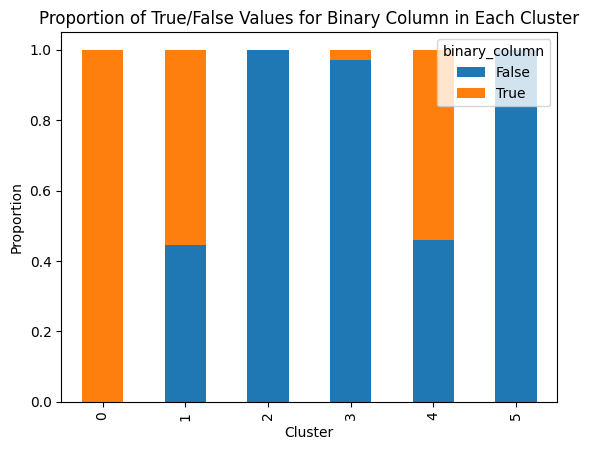

In [ ]:
# Create contingency table of true/false values for binary column in each cluster
df = pd.DataFrame({'cluster': kmeans.labels_, 'binary_column': data['type']})
contingency_table = pd.crosstab(df['cluster'], df['binary_column'], normalize='index')

# Plot stacked bar chart
contingency_table.plot(kind='bar', stacked=True)
plt.title('Proportion of True/False Values for Binary Column in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.show()

In [ ]:


# assume `df` is the original dataframe containing the data points
# and `kmeans` is the fitted KMeans model

# add the cluster labels as a new column to the dataframe


# iterate over each cluster and identify the top outliers
for i in range(kmeans.n_clusters):
    cluster_df = data[data['cluster'] == i]
    distances = np.linalg.norm(cluster_df - kmeans.cluster_centers_[i], axis=1)
    outliers = cluster_df.iloc[np.argsort(distances)[::-1][:10]]
    print(f"Top 10 outliers in cluster {i}:")
    print(outliers)


ValueError: Unable to coerce to Series, length must be 17: given 118109

In [ ]:
# Calculate distances from each data point to its nearest centroid
distances = np.min(cdist(tfidf.toarray(), kmeans.cluster_centers_, 'euclidean'), axis=1)

# Calculate the interquartile range and the upper and lower bounds for outlier detection
q1, q3 = np.percentile(distances, [25, 75])
iqr = q3 - q1
lower_bound = q1 - 10.5 * iqr
upper_bound = q3 + 10.5 * iqr

# Identify the outliers
outliers = np.where((distances < lower_bound) | (distances > upper_bound))[0]

# Print the number of outliers and their indices
print(f"Number of outliers: {len(outliers)}")
print("Outlier indices: ", outliers)

# Print the content of the outlier articles
for idx in outliers:
    print(f"\nOutlier {idx}:\n{data['content'][idx]}")
